# Data Preprocessing and Exploring


## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU, BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
# Directory of the whole Project, including images, checkpoints and model evaluations
FACEDATADIR = "G:/Datasets/Celeb_faces"

# Sub-directories of the FACEDATADIR directory
CSVPATH =  os.path.join(FACEDATADIR, "Anno") # home of the self-generated csv file
CHECKPOINTS = os.path.join(FACEDATADIR, "checkpoints") # saving the model checkpoints (weights)
NUMPY_FILES =  os.path.join(FACEDATADIR, "categorical") # home of the .npy training files
LOG =  os.path.join(FACEDATADIR, "training_log") # logs much of the training like loss and latent vectors
IMAGES =  os.path.join(FACEDATADIR, "images") # used for GENERATED images, not the training data
DATA_PATH = os.path.join(FACEDATADIR, "celeba") # extract just all the celeba pictures into this folder

# Sub-directories of the IMAGES directory
FULL_SAVE = os.path.join(IMAGES, "full")
CLASSES_SAVE = os.path.join(IMAGES, "classes")
DISCR_SAVE = os.path.join(IMAGES, "discr")
RANDOM_SAVE = os.path.join(IMAGES, "random")
LATENT_SAVE = os.path.join(IMAGES, "latent_space")

# Provided on the Github and in the .zip file
df = pd.read_csv(os.path.join(CSVPATH,"list_attr_celeba_2.csv"), delimiter=";")

## Exploration

### How many attributes / picture on average

In [3]:
no_fn = df.drop("filename", axis=1)

In [4]:
avg = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate("average")
std = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.std)
df_min = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.min)
df_max = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2).aggregate(np.max)
counts_series = no_fn.add(1,axis=0).sum(axis=1).apply(lambda x: x//2)

In [5]:
# Get the Indices of the highest and lowest amount of attributes per person
low_index = counts_series[counts_series==1].index[0]
high_index = counts_series[counts_series==20].index[0]

# Get the corresponding image-filenames
print(f"Only one attribute: \t{df.iloc[low_index].filename}")
print(f"Twenty attribute: \t{df.iloc[high_index].filename}")

Only one attribute: 	003259.jpg
Twenty attribute: 	014308.jpg


In [6]:
print(f"Average of Attributes/Person: \t{np.round(avg, decimals = 2)}")
print(f"Std of Attributes/Person: \t{np.round(std, decimals = 2)}")
print(f"Lowest amount of attributes: \t{np.round(df_min, decimals = 2)}")
print(f"Highest amount of attributes: \t{np.round(df_max, decimals = 2)}")

Average of Attributes/Person: 	9.03
Std of Attributes/Person: 	2.94
Lowest amount of attributes: 	1
Highest amount of attributes: 	20


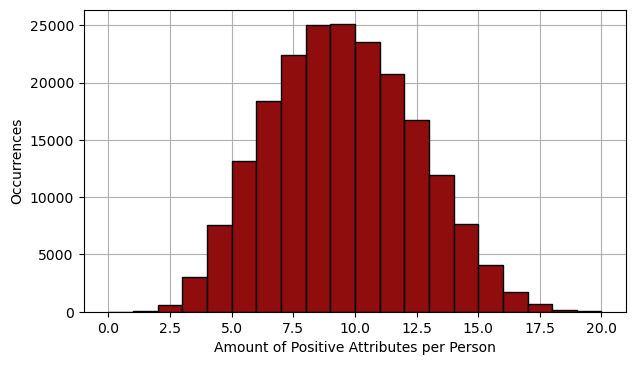

In [7]:
fig = plt.figure(figsize=(7,4),dpi=100)
plt.rc('axes', axisbelow=True)
plt.hist(counts_series, bins=20, color = "#900d0d", edgecolor= "black", range=(0,20))
plt.grid()
plt.xlabel("Amount of Positive Attributes per Person")
plt.ylabel("Occurrences")
plt.savefig(os.path.join(IMAGES,"attributes_histo.png"), dpi=300)
plt.show()

### Distribution of Attributes

In [8]:
import colorsys

In [9]:
no_fn = df.drop("filename", axis=1)

In [10]:
totals = no_fn.add(1,axis=0).sum(axis=0)//2

In [11]:
value = list(np.linspace(0.3,0.8, num=40))
N = 40
HSV_tuples = [(0.01, 0.9, value[x]) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
list_rgb = list(RGB_tuples)[::-1]

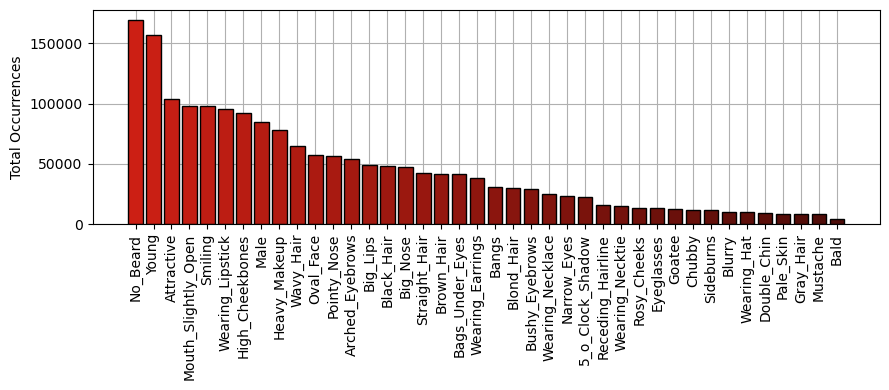

In [12]:
fig = plt.figure(figsize=(9,4),dpi=100)

plt.rc('axes', axisbelow=True)
plt.grid()
barlist = plt.bar(totals.sort_values(ascending=False).index, totals.sort_values(ascending=False), align="center", edgecolor="black")
plt.xticks(rotation='vertical')
for i in range(len(barlist)):
    barlist[i].set_color(list_rgb[i])
    barlist[i].set_edgecolor("black")
plt.ylabel("Total Occurrences")
plt.tight_layout()
plt.savefig(os.path.join(IMAGES,"attributes_distr.png"), dpi=300)
plt.show()

## Create numpy files

Here we create .npy files from the celeba images for training the model. Using a Data Loader was too inefficient in regards to running time. Therefore we had to settle on a subset of data.

In [ ]:
GENERATE_RES = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

targets = ["Eyeglasses", "Rosy_Cheeks", "Goatee"]

for col in targets:
    examplesize = 12000
    df_col = df[df[col]==1]
    
    #Only sample examplesize many when there are actually that many instances
    if(df_col["filename"].shape[0] >= examplesize):
        listdir_x = list(df_col["filename"].sample(examplesize, replace=False, random_state=1337))
    else:
        listdir_x = list(df_col["filename"])
        examplesize = len(listdir_x)
        
    print(f"Attribute {col} found {examplesize} examples.")

    training_binary_path = os.path.join(NUMPY_FILES,
            f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_{col}_{examplesize}.npy')

    print(f"Looking for file: {training_binary_path}")

    if not os.path.isfile(training_binary_path):
        start = time.time()
        print("Loading training images...")

        training_data = []
        faces_path = DATA_PATH
        for filename in tqdm(listdir_x):
            path = os.path.join(faces_path,filename)
            image = Image.open(path).resize((GENERATE_SQUARE,
                GENERATE_SQUARE),Image.ANTIALIAS)
            training_data.append(np.asarray(image))
        training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
        # float16 saves some space instead of float32
        training_data = training_data.astype(np.float16)
        # rescale to [-1,1]
        training_data = (training_data/127.5) - 1


        print("Saving training image binary...")
        np.save(training_binary_path,training_data)
        elapsed = time.time()-start
        print (f'Image preprocess time:',elapsed)
    else:
        print("Loading previous training pickle...")
        training_data = np.load(training_binary_path)

## Loading the Data - conditional GAN


In [13]:
# This would be the class header for 40 classes
#CLASS_HEADER = list(df.columns)[1:]

# For this experiment we only have 3 classes
CLASS_HEADER = ["Eyeglasses", "Rosy_Cheeks", "Goatee"]

In [14]:
# Load the Data - 3 classes

# needs to be done to initialze the dimension
X = np.load(os.path.join(FACEDATADIR, f"categorical/training_data_128_128_Eyeglasses_12000.npy"))
y = np.array([0]*12000)
ii=1

for klasse in CLASS_HEADER[1:]:
    X = np.concatenate([X, np.load(os.path.join(FACEDATADIR, f"categorical/training_data_128_128_{klasse}_12000.npy"))])
    y = np.concatenate([y, np.array([ii]*12000)])
    ii=ii+1

In [15]:
X.shape, y.shape

((36000, 128, 128, 3), (36000,))

# Conditional DCGAN

In [16]:
# define the standalone discriminator model
def define_cond_discriminator(in_shape=(128,128,3), n_classes=40):

    # label input
    in_label = Input(shape = (1,), name = "Input_Label")
    li = Embedding( n_classes , 50, name="Embedding_D")(in_label)

    n_nodes = in_shape[0] * in_shape[1] * 1 # 128*128*1
    li = Dense(n_nodes, name="Cond_D_Dense_1")(li)
    li = Reshape((in_shape[0], in_shape[1], 1), name="Cond_D_Reshape_1")(li)

    # image input
    in_image = Input(shape=in_shape, name="Cond_D_Input_Image")

    # concat label as a channel
    merge = Concatenate(name="Cond_D_Concatenate_1")([in_image, li])

    fe = Conv2D(64, (3,3), strides=(2,2), padding='same', name="Cond_D_Conv_1")(merge)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_1")(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_2")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_2")(fe)

    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_3")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_3")(fe)

    fe = Conv2D(512, (3,3), strides=(2,2), padding='same', name="Cond_D_conv_4")(fe)
    fe = LeakyReLU(alpha=0.2, name="Cond_D_LeakyRelu_4")(fe)
    
    fe = Flatten(name="Cond_D_Flatten_1")(fe)
    fe = Dropout(0.3, name="Cond_D_Dropout_1")(fe)

    out_layer = Dense(1, activation='sigmoid', name="Cond_D_Dense_2")(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [17]:
# define the standalone generator model
def define_cond_generator(latent_dim, n_classes=40):

    # label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 8*8*1
    li = Dense(n_nodes)(li)
    li = Reshape((8, 8, 1), name="Cond_G_Reshape_2")(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))

    n_nodes = 3*8*8    # since 3 channels
    gen = Dense(n_nodes)(in_lat)
    gen = ReLU()(gen)
    gen = Reshape((8, 8, 3), name="Cond_G_Reshape_3")(gen)

    merge = Concatenate()([gen, li])
    
    # 16x16
    gen = Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same')(merge)
    gen = ReLU()(gen)
    
    # 32x32
    gen = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    
    # 64x64
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)
    
    # 128x128
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = ReLU()(gen)

    # 1X1 conv, reduce channels to 3 - rgb
    out_layer = Conv2D(3, (7, 7), activation='tanh', padding='same')(gen)  # or 128, 128

    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_cond_gan(g_model, d_model):

    # Use this model to ONLY train generator
    d_model.trainable = False

    gen_noise, gen_label = g_model.input
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [18]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# select real samples
def generate_real_samples(X, y, n_samples):
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images and labels
    X, labels = X[ix], y[ix]
    # generate class labels
    target = ones((n_samples, 1))
    return [X, labels], target

# select real samples as suggested in the literature 
def generate_real_samples_smoothed(X, y, n_samples):
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images and labels
    X, labels = X[ix], y[ix]
    # generate class labels
    target = ones((n_samples, 1))*0.9 # change here if needed
    return [X, labels], target

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=3):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]
 

# generate points in latent space for saving progress
def generate_latent_points_fix(latent_dim, n_classes=3):
    # generate points in the latent space
    x_input = randn(latent_dim * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_classes, latent_dim)
    # generate labels
    labels = np.array(list(range(n_classes)))
    return z_input, labels

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    #print(f"SAFE. z_input: {z_input.shape}, labels_input:{labels_input.shape}")
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y
    
# here for the model with only 3 classes
def save_progress_full(generator, z, label, epoch, prefix = "", class_header=CLASS_HEADER):
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
    gen_imgs = generator.predict([z,label])
    
    for ax in axes:
        ax.imshow(gen_imgs[i] * 0.5 + 0.5)
        ax.set_title(f"{class_header[i]}")
        i=i+1
        ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False, labeltop=False, left=False, right=False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Epoch: {epoch}")
    plt.savefig(os.path.join(FULL_SAVE, f"{prefix}facegen_epoch_{epoch}_full.png"), dpi=300)
    #plt.show()
    plt.close(fig=fig)
    
    
# here for the model with all 40 classes
def save_progress_full_40(generator, z, label, epoch, prefix = "", class_header=CLASS_HEADER):
    i=0
    fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
    gen_imgs = generator.predict([z,label])
    for row in axes:
        for ax in row:
            ax.imshow(gen_imgs[i] * 0.5 + 0.5)
            ax.set_title(f"{class_header[i]}")
            i=i+1
            ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False, labeltop=False, left=False, right=False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Epoch: {epoch}")
    plt.savefig(os.path.join(FULL_SAVE, f"{prefix}facegen_epoch_{epoch}_full.png"), dpi=300)
    #plt.show()
    plt.close(fig=fig)
    
# independent of amount of classes
def save_progress_variety(generator, z, label, epoch, prefix = "", classname=""):
    i=0
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
    gen_imgs = generator.predict([z,label])
    for row in axes:
        for ax in row:
            ax.imshow(gen_imgs[i] * 0.5 + 0.5)
            i=i+1
            ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False, labeltop=False, left=False, right=False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"{classname} on epoch: {epoch}")
    plt.savefig(os.path.join(CLASSES_SAVE, f"{classname}_{prefix}epoch_{epoch}.png"), dpi=300)
    plt.close(fig=fig)
    #plt.show()
    
"""
Weights MUST HAVE layout: "prefix_cgan_{generator, discriminator}_epoch_X.h5"

Actually DEPRECATED, because weights are loaded manually to ensure everything goes right
"""
def load_latest_model(d, g, path, prefix=""):
    files = os.listdir(path)
    print(files)
    #print(files)
    max_d = 0
    max_g = 0
    for file in files: 
        print(file.split("_")[0])
        if (file.split("_")[0] == prefix):
            #print(file.split("_")[2])
            print(file)
            if (file.split("_")[2] == "generator"):
                maxx = int(file.split("_")[::-1][0].split(".")[0])
                #print(maxx)
                if (maxx>max_g):
                    max_g = maxx
            if (file.split("_")[2] == "discriminator"):
                maxx = int(file.split("_")[::-1][0].split(".")[0])
                #print(maxx)
                if (maxx>max_d):
                    max_d = maxx

    g.load_weights(os.path.join(path,f"{prefix}_cgan_generator_epoch_{max_g}.h5"))
    d.load_weights(os.path.join(path,f"{prefix}_cgan_discriminator_epoch_{max_g}.h5"))
    
    print(f"Loaded weights for epoch: {max_g}")
    return max_g

def plot_random_with_discr(d_model, g_model, epoch, latent_dim=100, save_pref=""):
    z, label = generate_latent_points_fix(latent_dim, n_classes=3)
    predd = g_model.predict([z, label])
    i=0
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
    gen_imgs = g_model.predict([z,label])
    d_pred = d_model.predict([predd,label])
    
    for ax in axes:
        ax.imshow(gen_imgs[i] * 0.5 + 0.5)
        ax.set_title(f"{CLASS_HEADER[i]}: {np.round(d_pred[i][0]*100, decimals=2)}%")
        i=i+1

        ax.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False, labelleft=False, labelright=False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Epoch {epoch} - Descriminator probabilities of being a real image")
    if(save_pref):
        plt.savefig(os.path.join(DISCR_SAVE+f"{save_pref}discriminator_epoch_{epoch}.png"), dpi=300)
    #plt.show()
    plt.close()

In [19]:
def train(g_model, d_model, gan_model, X, y , latent_dim, n_epochs=10000, n_batch=128, prefix="", epoch_start = 0, n_classes=40, class_header=CLASS_HEADER):
    # Only write csv header if first epoch
    if(epoch_start == 0):
        with open(os.path.join(FACEDATADIR, f"training_log/{prefix}training.csv"), "w+") as f:
            f.write("epoch; d_loss_real; d_loss_fake; g_loss\n")
    bat_per_epo = int(X.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # generate input and labels for progression tracking
    save_z_full, save_label_full = generate_latent_points_fix(latent_dim, n_classes=40)
    save_z_variety, _ = generate_latent_points_fix(latent_dim, n_classes=24) #small hack: 24 here to get 24 pictures, the actual class label comes later in this code
    if(epoch_start == 0):
        np.save(os.path.join(LOG, f"{prefix}save_z_full.npy"), save_z_full)
        np.save(os.path.join(LOG, f"{prefix}save_z_variety.npy"), save_z_variety)
    else:
        save_z_full = np.load(os.path.join(LOG, f"{prefix}save_z_full.npy"))
        save_z_variety = np.load(os.path.join(LOG, f"{prefix}save_z_variety.npy"))
    # manually enumerate epochs
    for i in range(epoch_start,n_epochs):
        start_t = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples_smoothed(X, y, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            if (j%50==0):
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        if (i%5==0):
            print("Saving the model...")
            g_model.save(os.path.join(CHECKPOINTS,f'{prefix}cgan_generator_epoch_{i}.h5'))
            d_model.save(os.path.join(CHECKPOINTS,f'{prefix}cgan_discriminator_epoch_{i}.h5'))
            print("Saving visual progress...")
            plot_random_with_discr(d_model, g_model, i, latent_dim=100, save_pref=prefix)
        if(i%7==0):
            for i_label in range(n_classes):
                save_label_variety = np.array([i_label]*save_z_variety.shape[0])
                save_progress_variety(g_model, save_z_variety, save_label_variety, i, prefix = prefix, classname=f"{class_header[i_label]}")
        with open(os.path.join(LOG, f"{prefix}training.csv"), "a") as f:
            f.write(f"{i}; {d_loss1}; {d_loss2}; {g_loss}\n")
        end_t = time.time()
        print(f"epoch {i}, elapsed time: {hms_string(end_t-start_t)}")
        if(n_classes == 40):
            save_progress_full_40(g_model, save_z_full, save_label_full, i, prefix = prefix, class_header=class_header)
        else:
            save_progress_full(g_model, save_z_full, save_label_full, i, prefix = prefix, class_header=class_header)

In [32]:
# initialize models
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_cond_discriminator(n_classes=40)
# create the generator
g_model = define_cond_generator(100, n_classes=40)
# create the gan
gan_model = define_cond_gan(g_model, d_model)

In [ ]:
# ONLY here is the prefix not ending with _ due to the pattern matching process of finding the right file
#n_epoch = load_latest_model(d_model, g_model, os.path.join(FACEDATADIR, "checkpoints"), prefix="full40_cDCGAN")

In [33]:
epoch = 95
d_model.load_weights(os.path.join(CHECKPOINTS,f"final_cgan_discriminator_epoch_{epoch}.h5"))
g_model.load_weights(os.path.join(CHECKPOINTS,f"final_cgan_generator_epoch_{epoch}.h5"))
epoch = epoch + 1

In [ ]:
train(g_model, d_model, gan_model, X,y, latent_dim, n_epochs=10000, n_batch=128, prefix="final_", n_classes=3, epoch_start=0)

# Visualize model performance

## Loss

In [105]:
training_log = pd.read_csv(os.path.join(LOG,"final_training.csv"), delimiter=";")

In [106]:
training_log.head()

,epoch,d_loss_real,d_loss_fake,g_loss
0,0,0.536238,0.249453,4.957487
1,1,0.472835,0.165468,2.652992
2,2,0.749032,0.091551,2.985757
3,3,0.509258,0.171112,3.290647
4,4,0.690904,0.093663,3.830461


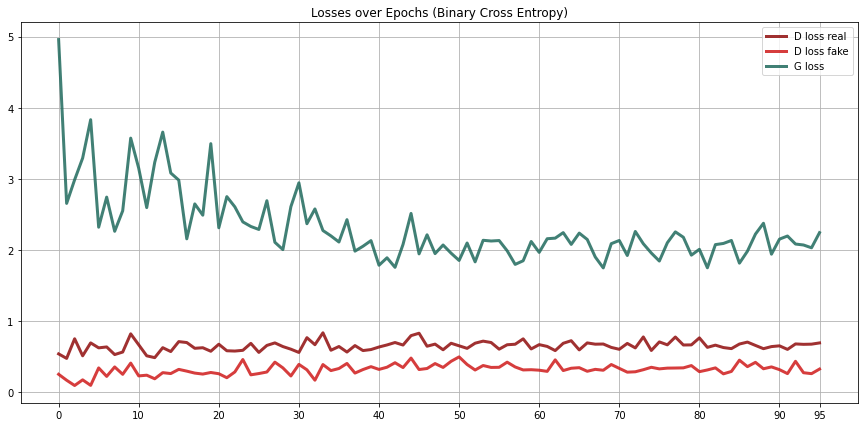

In [107]:
fig = plt.figure(figsize=(15,7))
plt.grid()
plt.plot(training_log[" d_loss_real"], c="#900d0d", label="D loss real", linewidth=3, alpha=0.85)
plt.plot(training_log[" d_loss_fake"], c="#cf1b1b", label="D loss fake", linewidth=3, alpha=0.85)
plt.plot(training_log[" g_loss"], c="#206a5d", label="G loss", linewidth=3, alpha=0.85)
plt.legend()
plt.title("Losses over Epochs (Binary Cross Entropy)")
plt.xticks([0,10,20,30,40,50,60,70,80,90,95])
plt.savefig(os.path.join(LOG,"final_training_fig.png"), dpi=300)
plt.show()

## Save randomly generated pictures

In [ ]:
[fake_pic, fake_label], _ = generate_fake_samples(g_model, 100, 300) # 300 instances

In [ ]:
for i in range(300):
    # rescale to 0-255, reshape and cast type 
    pic_data = (((fake_pic[i]+1)/2).reshape(128,128,3)*255).astype(np.uint8)
    pic = Image.fromarray(pic_data)
    pic.save(os.path.join(RANDOM_SAVE,f"{CLASS_HEADER[fake_label[i]]}_{i}.png"))

## [Explore latent space](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)

In [53]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    #print(vectors)
    return np.stack(vectors)

In [101]:
def save_latent_interpolations(path, n):
    for i in range(n):
        # generate points in latent space
        n = 6
        pts = generate_latent_points(100, n)

        # interpolate pairs
        results = None
        class_label = 0
        for i in range(0, n, 2):
            # interpolate points in latent space
            interpolated = interpolate_points(pts[0][i], pts[0][i+1])
            # generate images
            X = g_model.predict([interpolated, np.ones((10,))*class_label])
            class_label = class_label + 1
            # scale from [-1,1] to [0,1]
            X = (X + 1) / 2.0
            if results is None:
                results = X
            else:
                results = np.vstack((results, X))
        # plot the result
        #plot_generated(results, 10)

        fig, rows = plt.subplots(nrows=3, ncols=10, figsize=(25,7))
        i = 0
        for row in rows:
            for ax in row:
                ax.imshow(results[i])
                ax.axis("off")
                i=i+1

        #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.tight_layout()
        #plt.suptitle("Latent Space Interpolation for Glasses, Rosy Cheeks and Goatee")
        #plt.show()
        plt.savefig(os.path.join(path, f"latent_space_interpolation_{np.random.randint(0,999999)}.png"), dpi=300)
        plt.close(fig=fig)

In [104]:
save_latent_interpolations(LATENT_SAVE, 100)